# Section 1: Setup & Data Ingestion

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import time
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # <--- NEW FRIEND
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Config
TARGET_SIZE = (64, 64)
input_path = '/kaggle/input/plantvillage-dataset/color'

In [2]:
def load_data(data_dir, target_size=(64, 64)):
    """
    Loads images from folders, resizes them, and flattens them into 1D vectors.
    """
    features = []
    labels = []
    
    # Get the list of classes (folders)
    valid_classes = os.listdir(data_dir)
    print(f"Found {len(valid_classes)} classes. Ready to load.")

    for class_name in tqdm(valid_classes):
        class_path = os.path.join(data_dir, class_name)
        
        if not os.path.isdir(class_path):
            continue
            
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # Resize and Flatten
                img_resized = cv2.resize(img, target_size)
                img_flat = img_resized.flatten()
                
                features.append(img_flat)
                labels.append(class_name)
                
            except Exception as e:
                print(f"Error loading {img_name}: {e}")

    return np.array(features), np.array(labels)

In [3]:
# Load the data
print("Loading Data... (This will take time)")
X, y = load_data(input_path, target_size=TARGET_SIZE)

print("-" * 30)
print(f"Feature Matrix Shape: {X.shape}") # Likely (N_samples, 12288)
print(f"Labels Shape: {y.shape}")
print("-" * 30)

Loading Data... (This will take time)
Found 38 classes. Ready to load.


100%|██████████| 38/38 [06:36<00:00, 10.43s/it]


------------------------------
Feature Matrix Shape: (54305, 12288)
Labels Shape: (54305,)
------------------------------


# Section 2: Preprocessing & Splitting

In [4]:
# 1. Split (80/20)
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale (Crucial for PCA and SVM)
# We fit on Train, transform on Test to avoid data leakage
print("Scaling data (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Scaled. Mean is 0, Variance is 1.")

# Clean up raw X to save RAM
del X
gc.collect()

Splitting data...
Scaling data (StandardScaler)...
Data Scaled. Mean is 0, Variance is 1.


0

# Section 3: Dimensionality Reduction

In [5]:
# CODE CELL 5: Fast Randomized PCA
from sklearn.decomposition import PCA
import time

print("Starting Fast (Randomized) PCA Compression...")

# svd_solver='randomized' is the secret weapon for image data.
# It approximates the result much faster than standard PCA.
pca = PCA(n_components=150, svd_solver='randomized', random_state=42)

t0 = time.time()

# Fit and Transform in one go
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

t1 = time.time()

print(f"PCA Completed in {t1-t0:.2f} seconds.")
print(f"Feature reduction: {X_train_scaled.shape[1]} -> {X_train_pca.shape[1]}")

Starting Fast (Randomized) PCA Compression...
PCA Completed in 65.71 seconds.
Feature reduction: 12288 -> 150


# Section 4: The Baselines (Level 1 & 2)

In [6]:
from sklearn.metrics import accuracy_score

# Define the lightweight models to run on Compressed (PCA) Data
baseline_models = {
    "1. Dummy Classifier (Chance)": DummyClassifier(strategy="most_frequent"),
    "2. Nearest Centroid (Simple)": NearestCentroid(),
    "3. Linear SVM (PCA + Linear)": LinearSVC(C=0.01, dual=False, random_state=42)
}

results = {}

print("="*50)
print("Benchmarking Baselines on PCA Data (150 Features)")
print("="*50)

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    
    # Train on the compressed PCA data
    model.fit(X_train_pca, y_train)
    
    # Predict
    acc = model.score(X_test_pca, y_test)
    
    elapsed = time.time() - start
    results[name] = acc
    print(f"Accuracy: {acc:.4%} | Time: {elapsed:.2f}s")

Benchmarking Baselines on PCA Data (150 Features)

Training 1. Dummy Classifier (Chance)...
Accuracy: 10.5791% | Time: 0.08s

Training 2. Nearest Centroid (Simple)...
Accuracy: 37.2802% | Time: 0.27s

Training 3. Linear SVM (PCA + Linear)...
Accuracy: 66.1818% | Time: 127.43s


# Section 5: The Ensemble ("Heavy" Model)

In [7]:
print("\n" + "="*50)
print("Training Random Forest (High Accuracy Mode)")
print("="*50)

# We remove the depth limit (None) but increase n_estimators 
# to stabilize the variance.
rf_model = RandomForestClassifier(
    n_estimators=200,   # More trees = smoother decision boundary
    max_depth=None,     # Unlimited depth (Maximum Learning)
    n_jobs=-1,          # All cores
    random_state=42,
    verbose=1           # Shows progress so you know it's not frozen
)

t0 = time.time()

# Training on Scaled Data (Raw Pixels)
try:
    rf_model.fit(X_train_scaled, y_train)
    rf_acc = rf_model.score(X_test_scaled, y_test)
    
    t1 = time.time()
    
    results["4. Random Forest (Unbounded)"] = rf_acc
    print(f"Random Forest Accuracy: {rf_acc:.4%} | Time: {t1-t0:.2f}s")
    
except MemoryError:
    print("❌ CRASH PROTECTED: The model grew too large for RAM.")
    print("Suggestion: Re-run with max_depth=20")


Training Random Forest (High Accuracy Mode)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


Random Forest Accuracy: 68.5296% | Time: 567.48s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished


# Section 6: Evaluation


🏆 FINAL RESULTS LEADERBOARD 🏆
1. 4. Random Forest (Unbounded)        : 68.5296%
2. 3. Linear SVM (PCA + Linear)        : 66.1818%
3. 2. Nearest Centroid (Simple)        : 37.2802%
4. 1. Dummy Classifier (Chance)        : 10.5791%

✅ The Winner is: 4. Random Forest (Unbounded)
Generating detailed report for 4. Random Forest (Unbounded)...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished


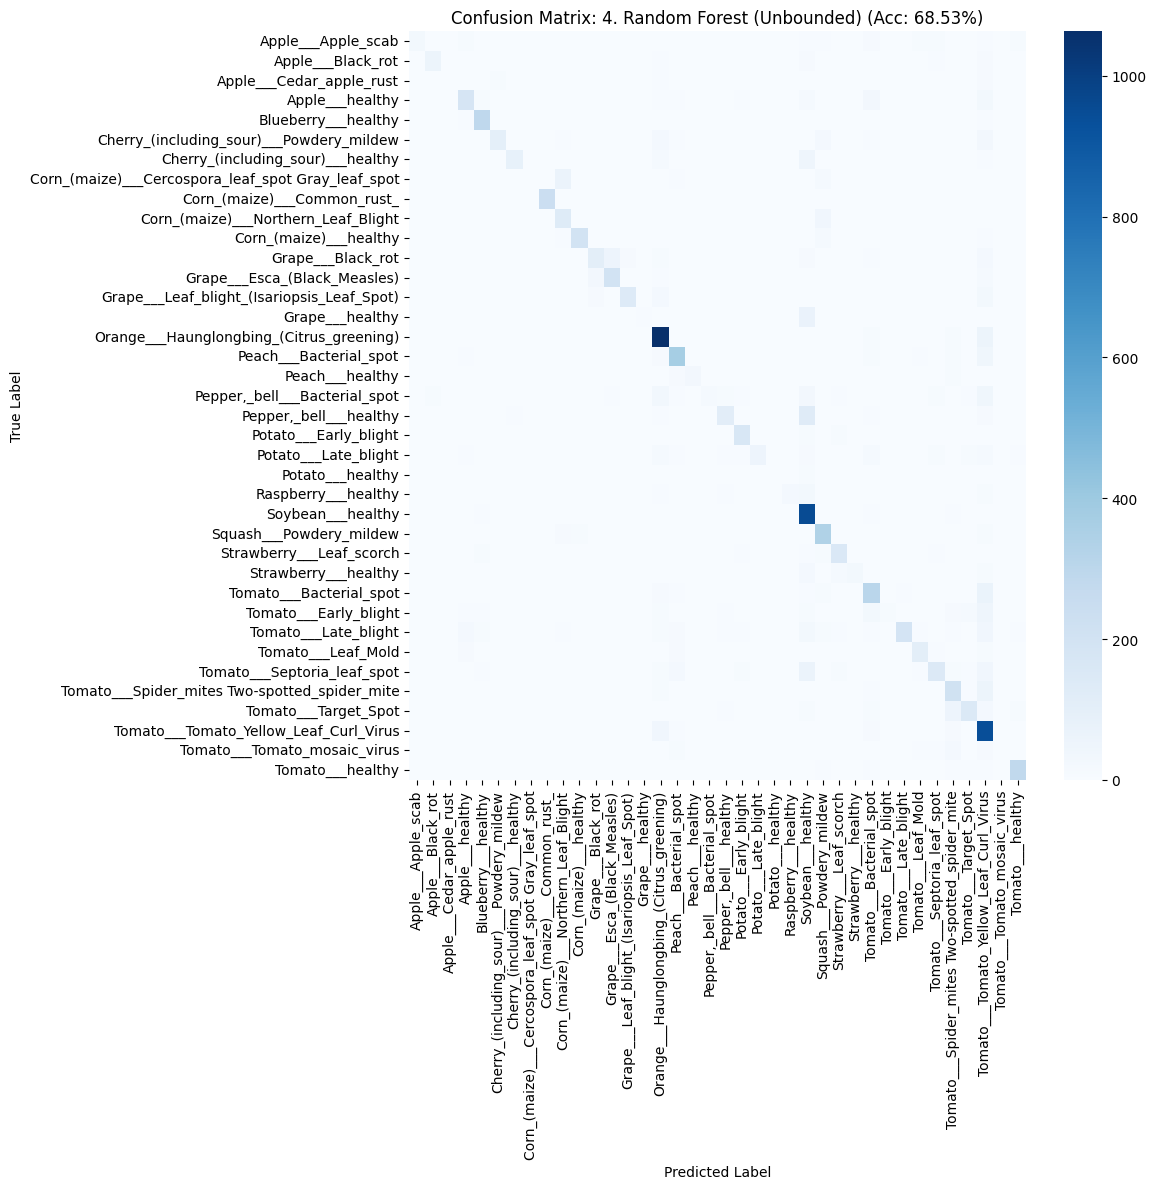


Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.93      0.23      0.36       119
                                 Apple___Black_rot       0.77      0.48      0.59       123
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        48
                                   Apple___healthy       0.64      0.59      0.61       305
                               Blueberry___healthy       0.80      0.89      0.84       324
          Cherry_(including_sour)___Powdery_mildew       0.75      0.48      0.59       213
                 Cherry_(including_sour)___healthy       0.82      0.52      0.64       166
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.04      0.07       111
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       240
               Corn_(maize)___Northern_Leaf_Blight     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1. Print Final Leaderboard
print("\n" + "="*40)
print("🏆 FINAL RESULTS LEADERBOARD 🏆")
print("="*40)

# Sort results by accuracy (High to Low)
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for rank, (name, score) in enumerate(sorted_results, 1):
    print(f"{rank}. {name:<35} : {score:.4%}")

# 2. Identify the Winner
best_model_name = sorted_results[0][0]
best_score = sorted_results[0][1]
print(f"\n✅ The Winner is: {best_model_name}")

# 3. Generate Predictions for the Winner (to make the matrix)
print(f"Generating detailed report for {best_model_name}...")

if "Random Forest" in best_model_name:
    # Random Forest used the SCALED data (Raw pixels)
    y_pred = rf_model.predict(X_test_scaled)
    
elif "Linear SVM" in best_model_name:
    # SVM used the PCA data
    y_pred = baseline_models["3. Linear SVM (PCA + Linear)"].predict(X_test_pca)
    
else:
    # Fallback for Dummy/Centroid
    # We need to map the "fancy name" back to the dictionary key if needed
    # (Assuming simple retrieval from the baseline_models dict)
    # Note: If you used specific names in cell 6, ensure they match here.
    model_key = [k for k in baseline_models.keys() if name in k]
    if model_key:
         y_pred = baseline_models[model_key[0]].predict(X_test_pca)

# 4. Plot Confusion Matrix
plt.figure(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred)

# We use the unique labels from y_test to label the axes correctly
labels = np.unique(y_test)

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.title(f"Confusion Matrix: {best_model_name} (Acc: {best_score:.2%})")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Print Classification Report (Precision/Recall per disease)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))